In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from models.imavae import IMAVAE

import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Generate Data without observed covariates

We construct the synthetic data for mediation analysis as below:
\begin{align*}
t &\sim \text{Bernoulli}(p) \\
\boldsymbol{z}_m &\sim \mathcal{N}(0, \sigma_m^2 \textbf{I}) + c_1 \mathbb{1}(t = 1) \\
\boldsymbol{x} &= f(\boldsymbol{z}_m) + c_2 \epsilon_{x} \\
y &= g(t, \boldsymbol{z}_m) + \epsilon_{y}
\end{align*}
where $0 < p < 1$ and $c \in \mathbb{R}$ are constants, $f$ and $g$ are nonlinear functions which are modeled by **un-trained** multi-layer perceptrons (MLPs), $\alpha$ and $\beta$ are the coefficients which build a linear relationship between $\boldsymbol{z}$ and $t, \boldsymbol{y}$, and $\epsilon_{x}$ and $\epsilon_{y}$ are Gaussian noise terms.

In [2]:
N = 6000
p, c1, c2, sigma_m, noise_scale = 0.5, 4, 0.1, 1, 0.1
x_dim, z_m_dim, hidden_dim_f, hidden_dim_g = 50, 2, 25, 20
f = nn.Sequential(
    nn.Linear(z_m_dim, hidden_dim_f), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim_f, x_dim)
)
g = nn.Sequential(
    nn.Linear(z_m_dim+1, hidden_dim_g), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim_g, hidden_dim_g), 
    nn.LeakyReLU(),
    nn.Linear(hidden_dim_g, 1)
)

T = np.random.binomial(n=1, p=[p for _ in range(N)]).reshape(-1,1)
Z_m0 = np.random.multivariate_normal(mean=np.zeros(z_m_dim), cov=sigma_m*np.eye(z_m_dim), size=N)
Z_m1 = Z_m0 + c1
Z_m = np.array([Z_m0[i,:] if T[i][0] == 0 else Z_m1[i,:] for i in range(N)])
with torch.no_grad():
    X = f(torch.tensor(Z_m).float()).numpy()
    X += c2 * np.random.randn(X.shape[0],X.shape[1])
# alpha = np.random.uniform(-2,2,size=1)
# beta = np.random.uniform(-1,1,size=z_m_dim)
noise = noise_scale * np.random.normal(size=N)
# Y = (alpha * T.reshape(-1) + Z_m @ beta + noise).reshape(-1,1)
Y = g(torch.tensor(np.concatenate([T,Z_m],axis=1)).float()).detach().cpu().numpy() + noise.reshape(-1,1)

The average causal mediation, direct, and total effect are defined as:
\begin{align}
\bar{\delta}(t) &= \mathbb{E}\left[ Y_i(t, M_i(1)) - Y_i(t, M_i(0)) \right] \\
\bar{\zeta}(t) &= \mathbb{E}\left[ Y_i(1, M_i(t)) - Y_i(0, M_i(t)) \right] \\
\bar{\tau} &= \mathbb{E}\left[ Y_i(1, M_i(1)) - Y_i(0, M_i(0)) \right]
\end{align}

In [3]:
Y0_M0 = g(torch.tensor(np.concatenate([np.zeros((N,1)),Z_m0],axis=1)).float()).detach().cpu().numpy() + noise.reshape(-1,1)
Y0_M1 = g(torch.tensor(np.concatenate([np.zeros((N,1)),Z_m1],axis=1)).float()).detach().cpu().numpy() + noise.reshape(-1,1)
Y1_M0 = g(torch.tensor(np.concatenate([np.ones((N,1)),Z_m0],axis=1)).float()).detach().cpu().numpy() + noise.reshape(-1,1)
Y1_M1 = g(torch.tensor(np.concatenate([np.ones((N,1)),Z_m1],axis=1)).float()).detach().cpu().numpy() + noise.reshape(-1,1)
acme_c = (Y0_M1 - Y0_M0).mean()
acme_t = (Y1_M1 - Y1_M0).mean()
ade_c = (Y1_M0 - Y0_M0).mean()
ade_t = (Y1_M1 - Y0_M1).mean()
ate = (Y1_M1 - Y0_M0).mean()
print("True ACME (control) = {:.4f}".format(acme_c))
print("True ACME (treatment) = {:.4f}".format(acme_t))
print("True ADE (control) = {:.4f}".format(ade_c))
print("True ADE (treatment) = {:.4f}".format(ade_t))
print("True ATE = {:.4f}".format(ate))

True ACME (control) = 0.0173
True ACME (treatment) = 0.0241
True ADE (control) = -0.0288
True ADE (treatment) = -0.0220
True ATE = -0.0047


# 2. Fit IMAVAE model and evaluate mediation effect

In [4]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, 
               optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1.)
_ = imavae.fit(
    X, T, Y, X_val=X, aux_val=T, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(T, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(T, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(T, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(T, treatment=True)
ate_mean, ate_std = imavae.ate_score(T)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 197, Best Recon MSE: 0.0100235, Best Pred Metric [0.0113


Saving the last epoch with training MSE: 0.0100163 and Pred Metric: [0.011368202, 0.011368202]
Loaded the best model from Epoch: 197 with MSE: 0.0100235 and Pred Metric: [0.011344406, 0.011344406]
ACME (control) = 0.1262 +/- 0.0004
ACME (treatment) = 0.1262 +/- 0.0004
ADE (control) = -0.1302 +/- 0.0000
ADE (treatment) = -0.1302 +/- 0.0000
ATE = -0.0040 +/- 0.0004
-------------------------------------
ACME err (control) = 0.1089 +/- 0.0004
ACME err (treatment) = 0.1021 +/- 0.0004
ADE err (control) = 0.1014 +/- 0.0000
ADE err (treatment) = 0.1081 +/- 0.0000
ATE err = 0.0007 +/- 0.0004


### 2.1 Does the latent feature learned by IMAVAE recover the true mediator?

/var/folders/f7/ng9rrn3j6nq2wy53cjpq4bmr0000gp/T/ipykernel_3650/2492788245.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)


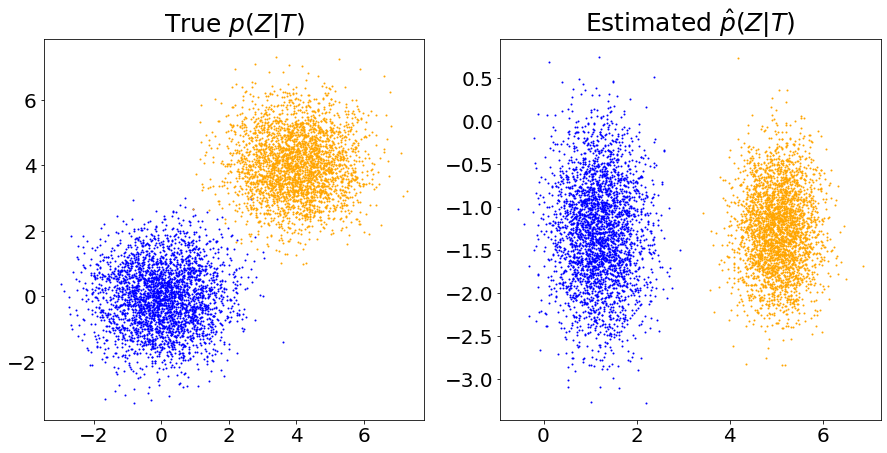

In [5]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    # Estimated z_m for factual outcomes
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(Z|T)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Estimated $\hat{p}(Z|T)$", size=25)
plt.savefig('./Figures/case_a_lr.png', dpi=1200)

### 2.2 What if we use a multi-layer perceptron for $g_{\boldsymbol{\gamma}}$ ?

In [6]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, n_sup_hidden_layers=1,
                n_sup_hidden_dim=10, optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1.)
_ = imavae.fit(
    X, T, Y, X_val=X, aux_val=T, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(T, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(T, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(T, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(T, treatment=True)
ate_mean, ate_std = imavae.ate_score(T)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 197, Best Recon MSE: 0.0100436, Best Pred Metric [0.0104


Saving the last epoch with training MSE: 0.0100677 and Pred Metric: [0.010473942, 0.010473942]
Loaded the best model from Epoch: 197 with MSE: 0.0100436 and Pred Metric: [0.0104975, 0.0104975]
ACME (control) = 0.0512 +/- 0.0005
ACME (treatment) = 0.0329 +/- 0.0002
ADE (control) = -0.0399 +/- 0.0003
ADE (treatment) = -0.0582 +/- 0.0001
ATE = -0.0069 +/- 0.0005
-------------------------------------
ACME err (control) = 0.0339 +/- 0.0005
ACME err (treatment) = 0.0089 +/- 0.0002
ADE err (control) = 0.0111 +/- 0.0003
ADE err (treatment) = 0.0361 +/- 0.0001
ATE err = 0.0022 +/- 0.0005


Text(0.5, 1.0, 'Estimated $\\hat{p}(Z|T)$')

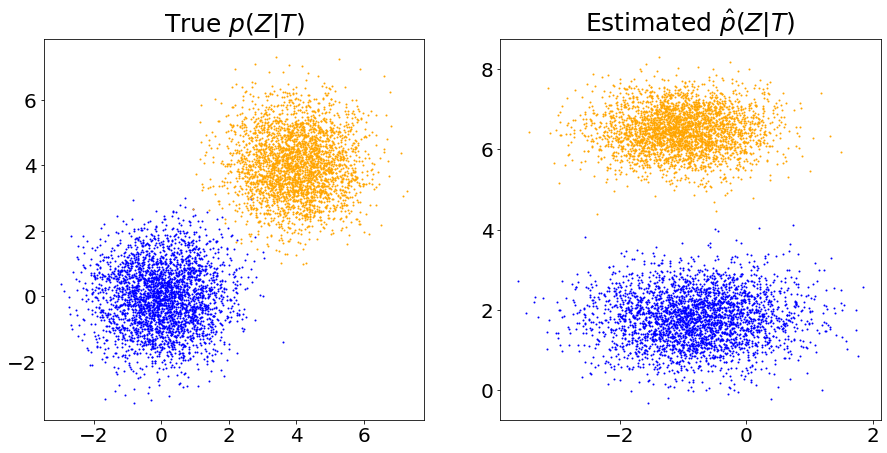

In [7]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    # Estimated z_m for factual outcomes
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,7))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_title("True $p(Z|T)$", size=25)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_title("Estimated $\hat{p}(Z|T)$", size=25)

#### 2.2.1 What if we increase the number of parameters of the MLP for $g_{\boldsymbol{\gamma}}$?

In [8]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, n_sup_hidden_layers=3,
                n_sup_hidden_dim=10, optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1.)
_ = imavae.fit(
    X, T, Y, X_val=X, aux_val=T, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(T, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(T, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(T, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(T, treatment=True)
ate_mean, ate_std = imavae.ate_score(T)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

Beginning Training


Epoch: 199, Best Epoch: 194, Best Recon MSE: 0.010022, Best Pred Metric [0.01015


Saving the last epoch with training MSE: 0.0100495 and Pred Metric: [0.01017276, 0.01017276]
Loaded the best model from Epoch: 194 with MSE: 0.010022 and Pred Metric: [0.010158141, 0.010158141]
ACME (control) = 0.0395 +/- 0.0007
ACME (treatment) = 0.0124 +/- 0.0004
ADE (control) = -0.0208 +/- 0.0007
ADE (treatment) = -0.0478 +/- 0.0002
ATE = -0.0084 +/- 0.0006
-------------------------------------
ACME err (control) = 0.0221 +/- 0.0007
ACME err (treatment) = 0.0116 +/- 0.0004
ADE err (control) = 0.0080 +/- 0.0007
ADE err (treatment) = 0.0257 +/- 0.0002
ATE err = 0.0037 +/- 0.0006
